# Модуль 6. Практическое задание 6

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

![separator1](https://i.imgur.com/ZUWYTii.png)

### Подготовка данных

In [5]:
titanic = pd.read_csv(r'D:\ДПО\data\train_titanic.csv')
titanic.columns = titanic.columns.str.lower()
titanic.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
titanic.shape

(891, 12)

In [7]:
titanic.isna().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

Удалим лишние столбцы:
1. passengerid, т.к. существенной информации колонка не несет
2. cabin, т.к. в столбце очень много пропущенных значений
3. ticket, т.к. данные содержат, и численные, и строковые значения. Столбец имеет плохую интерпретируемость

In [9]:
col_to_drop = ['cabin', 'passengerid', 'ticket']
titanic.drop(columns = col_to_drop, axis = 1, inplace = True)

В столбце name содержатся: фамилия, имя, титул пассажира. Имя и фамилия для нас не является существенным параметром, а вот титул может косвенно дать нам информацию о социальном статусе, возрасте, поле пассажира.

In [11]:
titanic['title'] = titanic['name'].str.extract(r',\s*([^\.]+)\.')
titanic.sample(10, random_state = 185)

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,title
355,0,3,"Vanden Steen, Mr. Leo Peter",male,28.0,0,0,9.5000,S,Mr
724,1,1,"Chambers, Mr. Norman Campbell",male,27.0,1,0,53.1000,S,Mr
337,1,1,"Burns, Miss. Elizabeth Margaret",female,41.0,0,0,134.5000,C,Miss
625,0,1,"Sutton, Mr. Frederick",male,61.0,0,0,32.3208,S,Mr
223,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,7.8958,S,Mr
743,0,3,"McNamee, Mr. Neal",male,24.0,1,0,16.1000,S,Mr
73,0,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,14.4542,C,Mr
300,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,7.7500,Q,Miss
252,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,26.5500,S,Mr
360,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,27.9000,S,Mr


In [12]:
titanic.title.value_counts()

title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

Титулов получилось много, обобщим их, чтобы при их перекодировании получилось меньше уникальных значений

In [14]:
title_dict = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Royal', 'Countess': 'Royal', 'the Countess' : 'Royal', 'Dona': 'Royal',
    'Sir': 'Royal', 'Jonkheer': 'Royal', 'Don': 'Royal',
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer', 'Rev': 'Officer', 'Dr': 'Officer'
}
titanic['title'] = titanic['title'].replace(title_dict)

In [15]:
titanic.title.value_counts()

title
Mr         517
Miss       185
Mrs        126
Master      40
Officer     18
Royal        5
Name: count, dtype: int64

In [16]:
titanic.drop('name', axis = 1, inplace = True)
titanic.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


![separator1](https://i.imgur.com/ZUWYTii.png)

### Выбор метрики

In [19]:
titanic.survived.value_counts(normalize = True).mul(100).round(2)

survived
0    61.62
1    38.38
Name: proportion, dtype: float64

В классах наблюдается некоторый дисбаланс: примерно 61% пассажиров не выжили, 39% выжили - поэтому метрика accuracy будет не показательной. В нашем случае одинаково важно учитывать оба рода ошибок: False Negative (пропустили выжившего) и False Positive (сказали, что пассажир выжил, но это не так). Подходящей метрикой будем считать F1-score, являющейся гармонической средней между precision и recall.

![separator1](https://i.imgur.com/ZUWYTii.png)

### Разбиение датасета на тренировочную и тестовую выборки

In [23]:
y = titanic['survived']
x = titanic.drop(['survived'], axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 185, test_size = 0.25)

### Построение бейзлайна

In [25]:
dummy_clf = DummyClassifier(strategy = 'most_frequent', random_state = 185)
dummy_clf.fit(x_train, y_train)
y_pred_dummy = dummy_clf.predict(x_test)
print(f'Accuracy-score for Dummy Classificator: {accuracy_score(y_test, y_pred_dummy):.4f}')
print(f'F1-score for Dummy Classificator: {f1_score(y_test, y_pred_dummy):.4f}')

Accuracy-score for Dummy Classificator: 0.6413
F1-score for Dummy Classificator: 0.0000


![separator1](https://i.imgur.com/ZUWYTii.png)

### Построение пайплайна

In [28]:
model = LogisticRegression(class_weight = 'balanced', max_iter = 1500, random_state = 185)

simple_imputer = SimpleImputer(strategy = 'median')
std_scaler = StandardScaler()

pipe_num = Pipeline([('imputer', simple_imputer), ('scaler', std_scaler)]) # pipeline для числовых признаков (заполняем пропущенные значения, нормализуем)

s_imputer = SimpleImputer(strategy = 'most_frequent')
ohe_encoder = OneHotEncoder(handle_unknown = 'ignore')
pipe_cat = Pipeline([('imputer', s_imputer), ('encoder', ohe_encoder)]) # pipeline для категориальных признаков (заполняем пропущенные значения, кодируем)

# объединяем пайплайны
col_transformer = ColumnTransformer(
    transformers = [
        ('num_preproc', pipe_num, [col for col in x_train.columns if x_train[col].dtype != 'object']),
        ('cat_preproc', pipe_cat, [col for col in x_train.columns if x_train[col].dtype == 'object'])
    ]
)


![separator1](https://i.imgur.com/ZUWYTii.png)

### Проверка на мультиколлинеарность

In [31]:
x_num = pipe_num.fit_transform(x_train[selector(dtype_exclude = "object")(x_train)]) # обрабатываем числовые признаки

num_cols = x_train[selector(dtype_exclude = "object")(x_train)].columns # возвращаем первоначальные названия колонок
x_num_df = pd.DataFrame(x_num, columns = num_cols, index = x_train.index)

In [32]:
corrs = x_num_df.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool))

<Axes: >

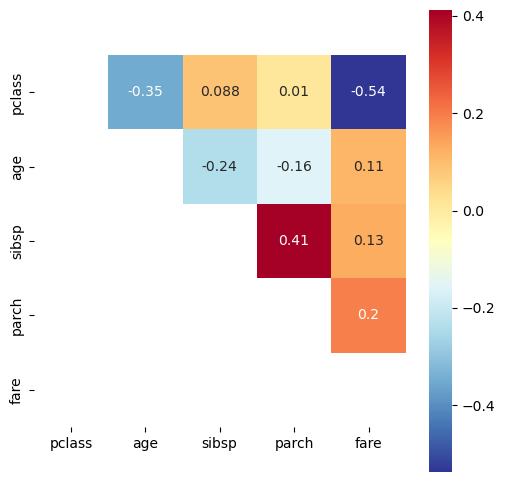

In [33]:
plt.figure(figsize = (6, 6))
sns.heatmap(upper_tri, cmap = "RdYlBu_r", square = True, annot = True)

Проблемы мультиколлинеарности не наблюдается, признаки имеют достаточно низкий уровень корреляции между собой

![separator1](https://i.imgur.com/ZUWYTii.png)

### Обучение модели Logistic Regression

In [37]:
final_pipe = Pipeline([('preproc', col_transformer),
                       ('model', model)])

final_pipe.fit(x_train, y_train)
preds = final_pipe.predict(x_test)

print(f'For Logistic Regression\nF1-score: {f1_score(y_test, preds, zero_division = 0):.4f}')
print(f'Precision: {precision_score(y_test, preds, zero_division = 0):.4f}')
print(f'Recall:    {recall_score(y_test, preds, zero_division = 0):.4f}')
print(f'Accuracy-score: {accuracy_score(y_test, preds):.4f}')

For Logistic Regression
F1-score: 0.7425
Precision: 0.7126
Recall:    0.7750
Accuracy-score: 0.8072


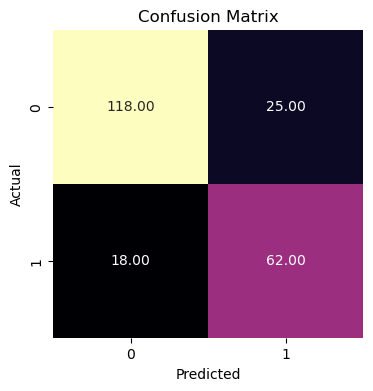

In [38]:
fig, ax = plt.subplots(figsize = (4,4))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, preds), annot = True, cbar = False, fmt = '.2f', cmap = 'magma')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Обучим более сложную модель (Random Forest) и сравним значения метрик

![separator1](https://i.imgur.com/ZUWYTii.png)

### Обучение модели Random Forest

In [42]:
rf_model = RandomForestClassifier(random_state = 185)

rf_pipe = Pipeline([
    ('preproc', col_transformer),
    ('model', rf_model)
])

rf_pipe.fit(x_train, y_train)
y_pred_rf = rf_pipe.predict(x_test)

print(f'For Random Forest\nF1-score: {f1_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred_rf):.4f}')
print(f'Accuracy-score: {accuracy_score(y_test, y_pred_rf):.4f}')

For Random Forest
F1-score: 0.7143
Precision: 0.7432
Recall:    0.6875
Accuracy-score: 0.8027


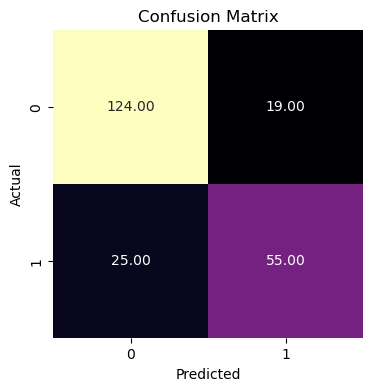

In [43]:
fig, ax = plt.subplots(figsize = (4,4))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, cbar = False, fmt = '.2f', cmap = 'magma')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()